# 03 - Systeme ELO

**Objectif** : Construire les ratings ELO sur l'historique Ligue 1 et verifier la coherence.

Le systeme ELO est notre deuxieme modele (poids 35% dans l'ensemble).
Il capture la force relative des equipes de facon incrementale.

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.models.elo import EloRating, EloMatch

sns.set_theme(style='whitegrid')
print('OK')

OK


In [2]:
# Charger les matchs
DATA_DIR = PROJECT_ROOT / 'data' / 'raw'
df = pd.read_csv(DATA_DIR / 'ligue1_2023.csv')
df['kickoff'] = pd.to_datetime(df['kickoff'])
df = df.sort_values('kickoff')
print(f'Matchs: {len(df)}')

Matchs: 306


## 1. Construire les ratings ELO

In [3]:
elo = EloRating(k_factor=32, home_advantage=100)

# Historique pour tracer l'evolution
history = {}

for _, row in df.iterrows():
    match = EloMatch(
        home_team=row['home_team'],
        away_team=row['away_team'],
        home_goals=int(row['home_score']),
        away_goals=int(row['away_score']),
    )
    new_home, new_away = elo.update(match)
    
    for team, rating in [(row['home_team'], new_home), (row['away_team'], new_away)]:
        if team not in history:
            history[team] = []
        history[team].append({'date': row['kickoff'], 'elo': rating})

# Classement final
ranking = sorted(elo.ratings.items(), key=lambda x: x[1], reverse=True)
print('\nClassement ELO final:\n')
for i, (team, rating) in enumerate(ranking, 1):
    print(f'{i:2d}. {team:30s} {rating:.0f}')


Classement ELO final:

 1. Paris Saint-Germain FC         1721
 2. AS Monaco FC                   1661
 3. Stade Brestois 29              1608
 4. Lille OSC                      1594
 5. Olympique Lyonnais             1584
 6. OGC Nice                       1550
 7. Olympique de Marseille         1531
 8. Racing Club de Lens            1524
 9. Stade Rennais FC 1901          1510
10. Montpellier HSC                1497
11. Toulouse FC                    1496
12. Stade de Reims                 1470
13. RC Strasbourg Alsace           1436
14. Le Havre AC                    1386
15. FC Lorient                     1371
16. FC Nantes                      1365
17. FC Metz                        1361
18. Clermont Foot 63               1336


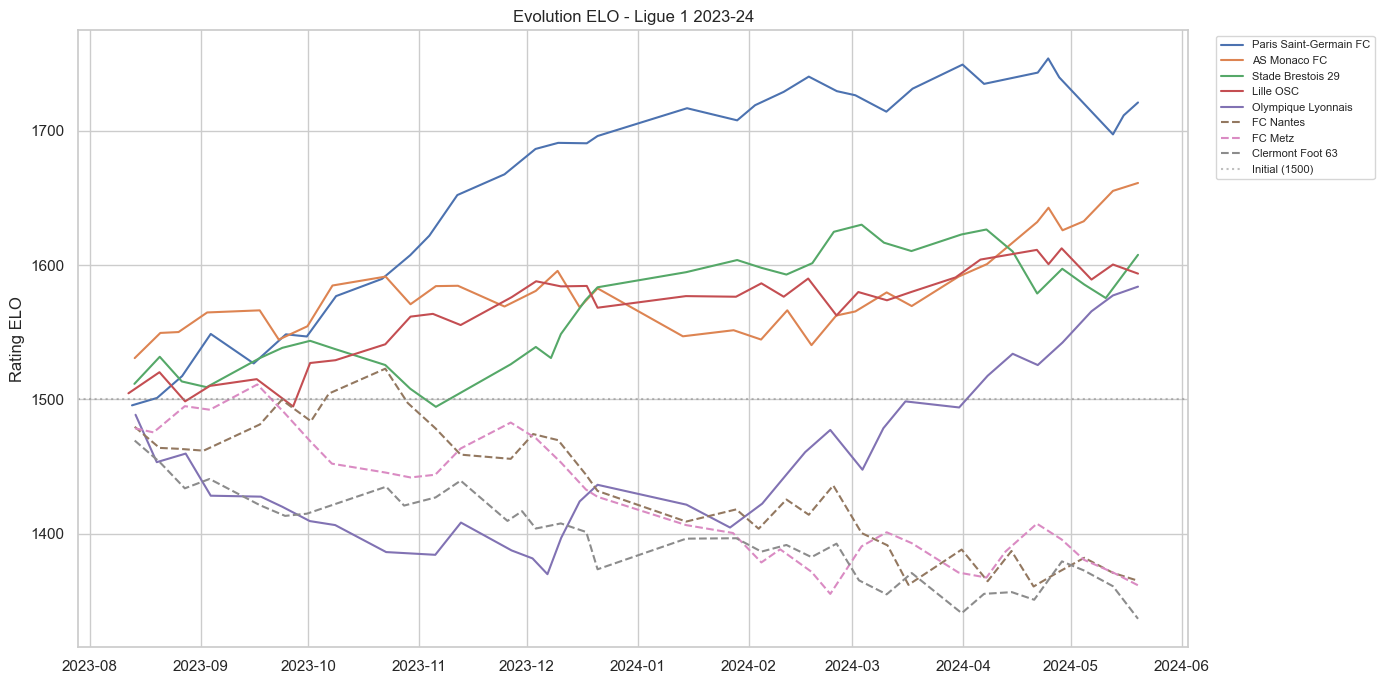

In [4]:
# Evolution ELO des top 5 et bottom 3
top_teams = [t for t, _ in ranking[:5]]
bottom_teams = [t for t, _ in ranking[-3:]]
plot_teams = top_teams + bottom_teams

fig, ax = plt.subplots(figsize=(14, 7))
for team in plot_teams:
    data = pd.DataFrame(history[team])
    style = '-' if team in top_teams else '--'
    ax.plot(data['date'], data['elo'], style, label=team, linewidth=1.5)

ax.axhline(y=1500, color='gray', linestyle=':', alpha=0.5, label='Initial (1500)')
ax.set_title('Evolution ELO - Ligue 1 2023-24')
ax.set_ylabel('Rating ELO')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.savefig(PROJECT_ROOT / 'data' / 'results' / 'elo_evolution.png', dpi=150)
plt.show()

## 2. Test de prediction 1X2

In [5]:
# Predictions ELO sur les derniers matchs (in-sample)
correct = 0
total = 0

# Reconstruire ELO match par match et predire
elo_test = EloRating(k_factor=32, home_advantage=100)

for i, (_, row) in enumerate(df.iterrows()):
    if i < 50:  # Besoin d'historique minimum
        elo_test.update(EloMatch(
            home_team=row['home_team'], away_team=row['away_team'],
            home_goals=int(row['home_score']), away_goals=int(row['away_score']),
        ))
        continue
    
    # Predire AVANT de mettre a jour
    pred = elo_test.predict_1x2(row['home_team'], row['away_team'])
    predicted = max(pred, key=pred.get)
    
    hs, as_ = int(row['home_score']), int(row['away_score'])
    actual = 'home' if hs > as_ else ('draw' if hs == as_ else 'away')
    
    if predicted == actual:
        correct += 1
    total += 1
    
    # Mettre a jour APRES
    elo_test.update(EloMatch(
        home_team=row['home_team'], away_team=row['away_team'],
        home_goals=int(row['home_score']), away_goals=int(row['away_score']),
    ))

print(f'Accuracy ELO (predict-then-update): {correct/total:.1%} ({correct}/{total})')
print(f'Baseline (toujours home win): {(df["home_score"] > df["away_score"]).mean():.1%}')

Accuracy ELO (predict-then-update): 45.7% (117/256)
Baseline (toujours home win): 39.2%


## Prochaine etape

Les ratings ELO sont prets. On passe au notebook **04** pour l'ensemble, puis au **05** pour le backtest complet.